In [201]:
# Librerias
import yaml
import psycopg2 
from psycopg2 import sql
from sqlalchemy import create_engine, text
from sqlalchemy.types import Integer, String, DateTime, Float
import pandas as pd
import os
import re
import unicodedata  
import matplotlib.pyplot as plt
import mplfinance as mpf

Data base connection

In [202]:
def load_config(file_path="config.yaml"):
    with open(file_path, "r") as file: # Abre el archivo en modo lectura ("r")
        return yaml.safe_load(file) # Carga y devuelve el contenido del archivo YAML

In [203]:
#conexion a la DB
config = load_config()
db_config = config["database"]

# Load credentials, se accede a los valores de la clave "database" del archivo config.yaml
db_user = db_config["user"]
db_password = db_config["password"]
db_host = db_config["host"]
db_port = db_config["port"]
db_name = db_config["name"]

# DB connection
conn = psycopg2.connect(
    dbname="postgres",
    user=db_user,
    password=db_password,
    host=db_host,
    port=db_port
)
conn.autocommit = True

In [204]:
#Creating the database 
db_name = "ETL_Project"

try:
    with conn.cursor() as cur:
        cur.execute(sql.SQL("CREATE DATABASE {}").format(sql.Identifier(db_name)))
        print(f"Base de datos '{db_name}' creada exitosamente.")
except psycopg2.errors.DuplicateDatabase:
    print(f"La base de datos '{db_name}' ya existe.")
finally:
    conn.close() #Close the database connection

La base de datos 'ETL_Project' ya existe.


File Reading for Review and Table Creation

In [205]:
# Specify the directory where the files are located
programs_path = "D:/JENN/Maestria IACD/ETL/ETL-Class-Project/Data/Programs.xlsx"

In [206]:
# Leer el archivo Excel
df_programs = pd.read_excel(programs_path)

# Mostrar las primeras filas del dataframe
df_programs.head()

d:\JENN\Maestria IACD\ETL\ETL-Class-Project\venv\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,CÓDIGO_INSTITUCIÓN_PADRE,CÓDIGO_INSTITUCIÓN,NOMBRE_INSTITUCIÓN,ESTADO_INSTITUCIÓN,CARÁCTER_ACADÉMICO,SECTOR,REGISTRO_UNICO,CÓDIGO_SNIES_DEL_PROGRAMA,CÓDIGO_ANTERIOR_ICFES,NOMBRE_DEL_PROGRAMA,TITULO_OTORGADO,ESTADO_PROGRAMA,JUSTIFICACION,JUSTIFICACION_DETALLADA,RECONOCIMIENTO_DEL_MINISTERIO,RESOLUCIÓN_DE_APROBACIÓN,FECHA_DE_RESOLUCIÓN,FECHA_EJECUTORIA,VIGENCIA_AÑOS,FECHA_DE_REGISTRO_EN_SNIES,CINE_F_2013_AC_CAMPO_AMPLIO,CINE_F_2013_AC_CAMPO_ESPECÍFIC,CINE_F_2013_AC_CAMPO_DETALLADO,ÁREA_DE_CONOCIMIENTO,NÚCLEO_BÁSICO_DEL_CONOCIMIENTO,NIVEL_ACADÉMICO,NIVEL_DE_FORMACIÓN,MODALIDAD,NÚMERO_CRÉDITOS,NÚMERO_PERIODOS_DE_DURACIÓN,PERIODICIDAD,SE_OFRECE_POR_CICLOS_PROPEDÉUT,PERIODICIDAD_ADMISIONES,PROGRAMA_EN_CONVENIO,DEPARTAMENTO_OFERTA_PROGRAMA,MUNICIPIO_OFERTA_PROGRAMA,COSTO_MATRÍCULA_ESTUD_NUEVOS,VIGENCIA TRANSITORIA,OBSERVACIÓN DECRETO 1174/23
0,1101,1101,UNIVERSIDAD NACIONAL DE COLOMBIA,Activa,Universidad,Oficial,NaN,19.0,110146580001100111100,ADMINISTRACION DE EMPRESAS,ADMINISTRADOR(A) DE EMPRESAS,Activo,NaN,NaN,Acreditación de alta calidad,22262.0,2023-11-23,2023-12-12,6,1998-03-21 08:21:46,Administración de Empresas y Derecho,Educación comercial y administración,Gestión y administración,"Economía, administración, contaduría y afines",Administración,Pregrado,Universitario,Presencial,164.0,10.0,Semestral,No,Semestral,N,"Bogotá, D.C.","Bogotá, D.C.",NaN,NaT,NaN
1,1101,1101,UNIVERSIDAD NACIONAL DE COLOMBIA,Activa,Universidad,Oficial,NaN,13.0,110143010101100111100,ANTROPOLOGIA,ANTROPOLOGO(A),Activo,NaN,NaN,Acreditación de alta calidad,NaN,NaT,NaT,8,1998-03-21 08:21:36,Arte y Humanidades,Humanidades (Excepto idiomas),Historia y arqueología,Ciencias sociales y humanas,Antropología y artes liberales,Pregrado,Universitario,Presencial,122.0,9.0,Semestral,No,Semestral,N,"Bogotá, D.C.","Bogotá, D.C.",NaN,NaT,NaN
2,1101,1101,UNIVERSIDAD NACIONAL DE COLOMBIA,Activa,Universidad,Oficial,NaN,30.0,110147200001100111100,ARQUITECTURA,ARQUITECTO(A),Activo,NaN,NaN,Acreditación de alta calidad,NaN,NaT,NaT,6,1998-03-21 08:22:13,"Ingeniería, Industria y Construcción",Arquitectura y construcción,Arquitectura y urbanismo,"Ingeniería, arquitectura, urbanismo y afines",Arquitectura y afines,Pregrado,Universitario,Presencial,179.0,10.0,Semestral,No,Semestral,N,"Bogotá, D.C.","Bogotá, D.C.",NaN,NaT,NaN
3,1101,1101,UNIVERSIDAD NACIONAL DE COLOMBIA,Activa,Universidad,Oficial,NaN,2497.0,110147300001100111100,ARTES PLASTICAS,MAESTRO EN ARTES PLASTICAS,Activo,NaN,NaN,Acreditación de alta calidad,NaN,NaT,NaT,8,1998-03-21 08:22:01,Arte y Humanidades,Artes,Bellas artes,Bellas artes,"Artes plásticas, visuales y afines",Pregrado,Universitario,Presencial,166.0,10.0,Semestral,No,Semestral,N,"Bogotá, D.C.","Bogotá, D.C.",NaN,NaT,NaN
4,1101,1101,UNIVERSIDAD NACIONAL DE COLOMBIA,Activa,Universidad,Oficial,NaN,31.0,110145740001100111100,BIOLOGIA,BIOLOGO(A),Activo,NaN,NaN,Acreditación de alta calidad,14191.0,2023-08-18,2023-09-06,8,1998-03-21 08:22:15,"Ciencias Naturales, Matemáticas y Estadística",Ciencias biológicas y afines,Biología,Matemáticas y ciencias naturales,"Biología, microbiología y afines",Pregrado,Universitario,Presencial,163.0,10.0,Semestral,No,Semestral,N,"Bogotá, D.C.","Bogotá, D.C.",NaN,NaT,NaN


In [207]:
# Crear la conexión a la base de datos usando SQLAlchemy
engine = create_engine(f'postgresql+psycopg2://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}')

# Cargar el dataframe a la base de datos
df_programs.to_sql('programs', engine, if_exists='replace', index=False, dtype={
    'CÓDIGO_INSTITUCIÓN_PADRE': String,
    'CÓDIGO_INSTITUCIÓN': String,
    'NOMBRE_INSTITUCIÓN': String,
    'ESTADO_INSTITUCIÓN': String,
    'CARÁCTER_ACADÉMICO': String,
    'SECTOR': String,
    'REGISTRO_UNICO': Float,
    'CÓDIGO_SNIES_DEL_PROGRAMA': Float,
    'CÓDIGO_ANTERIOR_ICFES': String,
    'NOMBRE_DEL_PROGRAMA': String,
    'TITULO_OTORGADO': String,
    'ESTADO_PROGRAMA': String,
    'JUSTIFICACION': Float,
    'JUSTIFICACION_DETALLADA': String,
    'RECONOCIMIENTO_DEL_MINISTERIO': String,
    'RESOLUCIÓN_DE_APROBACIÓN': Float,
    'FECHA_DE_RESOLUCIÓN': DateTime,
    'FECHA_EJECUTORIA': DateTime,
    'VIGENCIA_AÑOS': String,
    'FECHA_DE_REGISTRO_EN_SNIES': DateTime,
    'CINE_F_2013_AC_CAMPO_AMPLIO': String,
    'CINE_F_2013_AC_CAMPO_ESPECÍFIC': String,
    'CINE_F_2013_AC_CAMPO_DETALLADO': String,
    'ÁREA_DE_CONOCIMIENTO': String,
    'NÚCLEO_BÁSICO_DEL_CONOCIMIENTO': String,
    'NIVEL_ACADÉMICO': String,
    'NIVEL_DE_FORMACIÓN': String,
    'MODALIDAD': String,
    'NÚMERO_CRÉDITOS': Float,
    'NÚMERO_PERIODOS_DE_DURACIÓN': Float,
    'PERIODICIDAD': String,
    'SE_OFRECE_POR_CICLOS_PROPEDÉUT': String,
    'PERIODICIDAD_ADMISIONES': String,
    'PROGRAMA_EN_CONVENIO': String,
    'DEPARTAMENTO_OFERTA_PROGRAMA': String,
    'MUNICIPIO_OFERTA_PROGRAMA': String,
    'COSTO_MATRÍCULA_ESTUD_NUEVOS': Float,
    'VIGENCIA TRANSITORIA': DateTime,
    'OBSERVACIÓN DECRETO 1174/23': String
})

596

In [208]:
# Copia del dataframe programs
df_programs_copy = df_programs.copy()

In [209]:
# funcion que normaliza y quita acentos
def remove_accents(input_str):
    noaccent = unicodedata.normalize('NFKD', input_str)
    return u"".join([c for c in noaccent if not unicodedata.combining(c)])

In [210]:
# Uso .columns después del nombre del DataFrame para acceder y modificar los nombres de las columnas del DataFrame
df_programs_copy.columns = [remove_accents(col) for col in df_programs_copy.columns]
df_programs_copy.head()

,CODIGO_INSTITUCION_PADRE,CODIGO_INSTITUCION,NOMBRE_INSTITUCION,ESTADO_INSTITUCION,CARACTER_ACADEMICO,SECTOR,REGISTRO_UNICO,CODIGO_SNIES_DEL_PROGRAMA,CODIGO_ANTERIOR_ICFES,NOMBRE_DEL_PROGRAMA,TITULO_OTORGADO,ESTADO_PROGRAMA,JUSTIFICACION,JUSTIFICACION_DETALLADA,RECONOCIMIENTO_DEL_MINISTERIO,RESOLUCION_DE_APROBACION,FECHA_DE_RESOLUCION,FECHA_EJECUTORIA,VIGENCIA_ANOS,FECHA_DE_REGISTRO_EN_SNIES,CINE_F_2013_AC_CAMPO_AMPLIO,CINE_F_2013_AC_CAMPO_ESPECIFIC,CINE_F_2013_AC_CAMPO_DETALLADO,AREA_DE_CONOCIMIENTO,NUCLEO_BASICO_DEL_CONOCIMIENTO,NIVEL_ACADEMICO,NIVEL_DE_FORMACION,MODALIDAD,NUMERO_CREDITOS,NUMERO_PERIODOS_DE_DURACION,PERIODICIDAD,SE_OFRECE_POR_CICLOS_PROPEDEUT,PERIODICIDAD_ADMISIONES,PROGRAMA_EN_CONVENIO,DEPARTAMENTO_OFERTA_PROGRAMA,MUNICIPIO_OFERTA_PROGRAMA,COSTO_MATRICULA_ESTUD_NUEVOS,VIGENCIA TRANSITORIA,OBSERVACION DECRETO 1174/23
0,1101,1101,UNIVERSIDAD NACIONAL DE COLOMBIA,Activa,Universidad,Oficial,NaN,19.0,110146580001100111100,ADMINISTRACION DE EMPRESAS,ADMINISTRADOR(A) DE EMPRESAS,Activo,NaN,NaN,Acreditación de alta calidad,22262.0,2023-11-23,2023-12-12,6,1998-03-21 08:21:46,Administración de Empresas y Derecho,Educación comercial y administración,Gestión y administración,"Economía, administración, contaduría y afines",Administración,Pregrado,Universitario,Presencial,164.0,10.0,Semestral,No,Semestral,N,"Bogotá, D.C.","Bogotá, D.C.",NaN,NaT,NaN
1,1101,1101,UNIVERSIDAD NACIONAL DE COLOMBIA,Activa,Universidad,Oficial,NaN,13.0,110143010101100111100,ANTROPOLOGIA,ANTROPOLOGO(A),Activo,NaN,NaN,Acreditación de alta calidad,NaN,NaT,NaT,8,1998-03-21 08:21:36,Arte y Humanidades,Humanidades (Excepto idiomas),Historia y arqueología,Ciencias sociales y humanas,Antropología y artes liberales,Pregrado,Universitario,Presencial,122.0,9.0,Semestral,No,Semestral,N,"Bogotá, D.C.","Bogotá, D.C.",NaN,NaT,NaN
2,1101,1101,UNIVERSIDAD NACIONAL DE COLOMBIA,Activa,Universidad,Oficial,NaN,30.0,110147200001100111100,ARQUITECTURA,ARQUITECTO(A),Activo,NaN,NaN,Acreditación de alta calidad,NaN,NaT,NaT,6,1998-03-21 08:22:13,"Ingeniería, Industria y Construcción",Arquitectura y construcción,Arquitectura y urbanismo,"Ingeniería, arquitectura, urbanismo y afines",Arquitectura y afines,Pregrado,Universitario,Presencial,179.0,10.0,Semestral,No,Semestral,N,"Bogotá, D.C.","Bogotá, D.C.",NaN,NaT,NaN
3,1101,1101,UNIVERSIDAD NACIONAL DE COLOMBIA,Activa,Universidad,Oficial,NaN,2497.0,110147300001100111100,ARTES PLASTICAS,MAESTRO EN ARTES PLASTICAS,Activo,NaN,NaN,Acreditación de alta calidad,NaN,NaT,NaT,8,1998-03-21 08:22:01,Arte y Humanidades,Artes,Bellas artes,Bellas artes,"Artes plásticas, visuales y afines",Pregrado,Universitario,Presencial,166.0,10.0,Semestral,No,Semestral,N,"Bogotá, D.C.","Bogotá, D.C.",NaN,NaT,NaN
4,1101,1101,UNIVERSIDAD NACIONAL DE COLOMBIA,Activa,Universidad,Oficial,NaN,31.0,110145740001100111100,BIOLOGIA,BIOLOGO(A),Activo,NaN,NaN,Acreditación de alta calidad,14191.0,2023-08-18,2023-09-06,8,1998-03-21 08:22:15,"Ciencias Naturales, Matemáticas y Estadística",Ciencias biológicas y afines,Biología,Matemáticas y ciencias naturales,"Biología, microbiología y afines",Pregrado,Universitario,Presencial,163.0,10.0,Semestral,No,Semestral,N,"Bogotá, D.C.","Bogotá, D.C.",NaN,NaT,NaN


In [211]:
df_programs_copy.drop(columns=
            ['CODIGO_INSTITUCION','CODIGO_ANTERIOR_ICFES','TITULO_OTORGADO','JUSTIFICACION',
            'JUSTIFICACION_DETALLADA','FECHA_EJECUTORIA','RESOLUCION_DE_APROBACION',
            'FECHA_DE_RESOLUCION','PROGRAMA_EN_CONVENIO','VIGENCIA TRANSITORIA','VIGENCIA_ANOS',
            'OBSERVACION DECRETO 1174/23'], inplace=True)
df_programs_copy.head()

,CODIGO_INSTITUCION_PADRE,NOMBRE_INSTITUCION,ESTADO_INSTITUCION,CARACTER_ACADEMICO,SECTOR,REGISTRO_UNICO,CODIGO_SNIES_DEL_PROGRAMA,NOMBRE_DEL_PROGRAMA,ESTADO_PROGRAMA,RECONOCIMIENTO_DEL_MINISTERIO,FECHA_DE_REGISTRO_EN_SNIES,CINE_F_2013_AC_CAMPO_AMPLIO,CINE_F_2013_AC_CAMPO_ESPECIFIC,CINE_F_2013_AC_CAMPO_DETALLADO,AREA_DE_CONOCIMIENTO,NUCLEO_BASICO_DEL_CONOCIMIENTO,NIVEL_ACADEMICO,NIVEL_DE_FORMACION,MODALIDAD,NUMERO_CREDITOS,NUMERO_PERIODOS_DE_DURACION,PERIODICIDAD,SE_OFRECE_POR_CICLOS_PROPEDEUT,PERIODICIDAD_ADMISIONES,DEPARTAMENTO_OFERTA_PROGRAMA,MUNICIPIO_OFERTA_PROGRAMA,COSTO_MATRICULA_ESTUD_NUEVOS
0,1101,UNIVERSIDAD NACIONAL DE COLOMBIA,Activa,Universidad,Oficial,NaN,19.0,ADMINISTRACION DE EMPRESAS,Activo,Acreditación de alta calidad,1998-03-21 08:21:46,Administración de Empresas y Derecho,Educación comercial y administración,Gestión y administración,"Economía, administración, contaduría y afines",Administración,Pregrado,Universitario,Presencial,164.0,10.0,Semestral,No,Semestral,"Bogotá, D.C.","Bogotá, D.C.",NaN
1,1101,UNIVERSIDAD NACIONAL DE COLOMBIA,Activa,Universidad,Oficial,NaN,13.0,ANTROPOLOGIA,Activo,Acreditación de alta calidad,1998-03-21 08:21:36,Arte y Humanidades,Humanidades (Excepto idiomas),Historia y arqueología,Ciencias sociales y humanas,Antropología y artes liberales,Pregrado,Universitario,Presencial,122.0,9.0,Semestral,No,Semestral,"Bogotá, D.C.","Bogotá, D.C.",NaN
2,1101,UNIVERSIDAD NACIONAL DE COLOMBIA,Activa,Universidad,Oficial,NaN,30.0,ARQUITECTURA,Activo,Acreditación de alta calidad,1998-03-21 08:22:13,"Ingeniería, Industria y Construcción",Arquitectura y construcción,Arquitectura y urbanismo,"Ingeniería, arquitectura, urbanismo y afines",Arquitectura y afines,Pregrado,Universitario,Presencial,179.0,10.0,Semestral,No,Semestral,"Bogotá, D.C.","Bogotá, D.C.",NaN
3,1101,UNIVERSIDAD NACIONAL DE COLOMBIA,Activa,Universidad,Oficial,NaN,2497.0,ARTES PLASTICAS,Activo,Acreditación de alta calidad,1998-03-21 08:22:01,Arte y Humanidades,Artes,Bellas artes,Bellas artes,"Artes plásticas, visuales y afines",Pregrado,Universitario,Presencial,166.0,10.0,Semestral,No,Semestral,"Bogotá, D.C.","Bogotá, D.C.",NaN
4,1101,UNIVERSIDAD NACIONAL DE COLOMBIA,Activa,Universidad,Oficial,NaN,31.0,BIOLOGIA,Activo,Acreditación de alta calidad,1998-03-21 08:22:15,"Ciencias Naturales, Matemáticas y Estadística",Ciencias biológicas y afines,Biología,Matemáticas y ciencias naturales,"Biología, microbiología y afines",Pregrado,Universitario,Presencial,163.0,10.0,Semestral,No,Semestral,"Bogotá, D.C.","Bogotá, D.C.",NaN


In [212]:
df_programs_copy.dtypes

CODIGO_INSTITUCION_PADRE                  object
NOMBRE_INSTITUCION                        object
ESTADO_INSTITUCION                        object
CARACTER_ACADEMICO                        object
SECTOR                                    object
REGISTRO_UNICO                           float64
CODIGO_SNIES_DEL_PROGRAMA                float64
NOMBRE_DEL_PROGRAMA                       object
ESTADO_PROGRAMA                           object
RECONOCIMIENTO_DEL_MINISTERIO             object
FECHA_DE_REGISTRO_EN_SNIES        datetime64[ns]
CINE_F_2013_AC_CAMPO_AMPLIO               object
CINE_F_2013_AC_CAMPO_ESPECIFIC            object
CINE_F_2013_AC_CAMPO_DETALLADO            object
AREA_DE_CONOCIMIENTO                      object
NUCLEO_BASICO_DEL_CONOCIMIENTO            object
NIVEL_ACADEMICO                           object
NIVEL_DE_FORMACION                        object
MODALIDAD                                 object
NUMERO_CREDITOS                          float64
NUMERO_PERIODOS_DE_D

In [213]:
# Convierto tipos de datos a numerico
df_programs_copy['CODIGO_INSTITUCION_PADRE'] = pd.to_numeric(df_programs_copy['CODIGO_INSTITUCION_PADRE'], errors='coerce').astype('Int32')
df_programs_copy['REGISTRO_UNICO'] = pd.to_numeric(df_programs_copy['REGISTRO_UNICO'], errors='coerce').astype('Int32')
df_programs_copy['CODIGO_SNIES_DEL_PROGRAMA'] = pd.to_numeric(df_programs_copy['CODIGO_SNIES_DEL_PROGRAMA'], errors='coerce').astype('Int32')
df_programs_copy['NUMERO_CREDITOS'] = pd.to_numeric(df_programs_copy['NUMERO_CREDITOS'], errors='coerce').astype('Int32')
df_programs_copy['NUMERO_PERIODOS_DE_DURACION'] = pd.to_numeric(df_programs_copy['NUMERO_PERIODOS_DE_DURACION'], errors='coerce').astype('Int32')
df_programs_copy['COSTO_MATRICULA_ESTUD_NUEVOS'] = pd.to_numeric(df_programs_copy['COSTO_MATRICULA_ESTUD_NUEVOS'], errors='coerce').astype('Int32')


In [214]:
df_programs_copy['NOMBRE_INSTITUCION'] = df_programs_copy['NOMBRE_INSTITUCION'].astype('string')
df_programs_copy['SECTOR'] = df_programs_copy['SECTOR'].astype('string')
df_programs_copy['NOMBRE_DEL_PROGRAMA'] = df_programs_copy['NOMBRE_DEL_PROGRAMA'].astype('string')
df_programs_copy['ESTADO_INSTITUCION'] = df_programs_copy['ESTADO_INSTITUCION'].astype('category')
df_programs_copy['CARACTER_ACADEMICO'] = df_programs_copy['CARACTER_ACADEMICO'].astype('category')
df_programs_copy['ESTADO_PROGRAMA'] = df_programs_copy['ESTADO_PROGRAMA'].astype('category')
df_programs_copy['RECONOCIMIENTO_DEL_MINISTERIO'] = df_programs_copy['RECONOCIMIENTO_DEL_MINISTERIO'].astype('category')
df_programs_copy['CINE_F_2013_AC_CAMPO_AMPLIO'] = df_programs_copy['CINE_F_2013_AC_CAMPO_AMPLIO'].astype('category')
df_programs_copy['CINE_F_2013_AC_CAMPO_ESPECIFIC'] = df_programs_copy['CINE_F_2013_AC_CAMPO_ESPECIFIC'].astype('category')
df_programs_copy['CINE_F_2013_AC_CAMPO_DETALLADO'] = df_programs_copy['CINE_F_2013_AC_CAMPO_DETALLADO'].astype('category')
df_programs_copy['AREA_DE_CONOCIMIENTO'] = df_programs_copy['AREA_DE_CONOCIMIENTO'].astype('category')
df_programs_copy['NUCLEO_BASICO_DEL_CONOCIMIENTO'] = df_programs_copy['NUCLEO_BASICO_DEL_CONOCIMIENTO'].astype('category')
df_programs_copy['NIVEL_ACADEMICO'] = df_programs_copy['NIVEL_ACADEMICO'].astype('category')
df_programs_copy['NIVEL_DE_FORMACION'] = df_programs_copy['NIVEL_DE_FORMACION'].astype('category')
df_programs_copy['MODALIDAD'] = df_programs_copy['MODALIDAD'].astype('category')
df_programs_copy['PERIODICIDAD'] = df_programs_copy['PERIODICIDAD'].astype('category')
df_programs_copy['SE_OFRECE_POR_CICLOS_PROPEDEUT'] = df_programs_copy['SE_OFRECE_POR_CICLOS_PROPEDEUT'].astype('category')
df_programs_copy['PERIODICIDAD_ADMISIONES'] = df_programs_copy['PERIODICIDAD_ADMISIONES'].astype('category')
df_programs_copy['PERIODICIDAD'] = df_programs_copy['PERIODICIDAD_ADMISIONES'].astype('category')
df_programs_copy['DEPARTAMENTO_OFERTA_PROGRAMA'] = df_programs_copy['DEPARTAMENTO_OFERTA_PROGRAMA'].astype('category')
df_programs_copy['MUNICIPIO_OFERTA_PROGRAMA'] = df_programs_copy['MUNICIPIO_OFERTA_PROGRAMA'].astype('category')


In [215]:
#convierto dato de fecha
df_programs_copy['FECHA_DE_REGISTRO_EN_SNIES'] = pd.to_datetime(df_programs_copy['FECHA_DE_REGISTRO_EN_SNIES'])

In [216]:
# Crear columnas de año y mes de creación en SNIES
df_programs_copy['AÑO_CREACION_SNIES'] = df_programs_copy['FECHA_DE_REGISTRO_EN_SNIES'].dt.year
df_programs_copy['MES_CREACION_SNIES'] = df_programs_copy['FECHA_DE_REGISTRO_EN_SNIES'].dt.month

df_programs_copy['AÑO_CREACION_SNIES'] = pd.to_datetime(df_programs_copy['AÑO_CREACION_SNIES'], format='%Y', errors='coerce')
df_programs_copy['MES_CREACION_SNIES'] = pd.to_datetime(df_programs_copy['MES_CREACION_SNIES'], format='%M', errors='coerce')

# Verificar las primeras filas para confirmar los cambios
df_programs_copy[['FECHA_DE_REGISTRO_EN_SNIES', 'AÑO_CREACION_SNIES', 'MES_CREACION_SNIES']].head()

,FECHA_DE_REGISTRO_EN_SNIES,AÑO_CREACION_SNIES,MES_CREACION_SNIES
0,1998-03-21 08:21:46,1998-01-01,1900-01-01 00:03:00
1,1998-03-21 08:21:36,1998-01-01,1900-01-01 00:03:00
2,1998-03-21 08:22:13,1998-01-01,1900-01-01 00:03:00
3,1998-03-21 08:22:01,1998-01-01,1900-01-01 00:03:00
4,1998-03-21 08:22:15,1998-01-01,1900-01-01 00:03:00


In [217]:
df_programs_copy.dtypes

CODIGO_INSTITUCION_PADRE                   Int32
NOMBRE_INSTITUCION                string[python]
ESTADO_INSTITUCION                      category
CARACTER_ACADEMICO                      category
SECTOR                            string[python]
REGISTRO_UNICO                             Int32
CODIGO_SNIES_DEL_PROGRAMA                  Int32
NOMBRE_DEL_PROGRAMA               string[python]
ESTADO_PROGRAMA                         category
RECONOCIMIENTO_DEL_MINISTERIO           category
FECHA_DE_REGISTRO_EN_SNIES        datetime64[ns]
CINE_F_2013_AC_CAMPO_AMPLIO             category
CINE_F_2013_AC_CAMPO_ESPECIFIC          category
CINE_F_2013_AC_CAMPO_DETALLADO          category
AREA_DE_CONOCIMIENTO                    category
NUCLEO_BASICO_DEL_CONOCIMIENTO          category
NIVEL_ACADEMICO                         category
NIVEL_DE_FORMACION                      category
MODALIDAD                               category
NUMERO_CREDITOS                            Int32
NUMERO_PERIODOS_DE_D

In [218]:
# Reemplazo valores vacios por 0
df_programs_copy[['REGISTRO_UNICO', 'COSTO_MATRICULA_ESTUD_NUEVOS']] = df_programs_copy[['REGISTRO_UNICO', 'COSTO_MATRICULA_ESTUD_NUEVOS']].fillna(0)
df_programs_copy.head()

,CODIGO_INSTITUCION_PADRE,NOMBRE_INSTITUCION,ESTADO_INSTITUCION,CARACTER_ACADEMICO,SECTOR,REGISTRO_UNICO,CODIGO_SNIES_DEL_PROGRAMA,NOMBRE_DEL_PROGRAMA,ESTADO_PROGRAMA,RECONOCIMIENTO_DEL_MINISTERIO,FECHA_DE_REGISTRO_EN_SNIES,CINE_F_2013_AC_CAMPO_AMPLIO,CINE_F_2013_AC_CAMPO_ESPECIFIC,CINE_F_2013_AC_CAMPO_DETALLADO,AREA_DE_CONOCIMIENTO,NUCLEO_BASICO_DEL_CONOCIMIENTO,NIVEL_ACADEMICO,NIVEL_DE_FORMACION,MODALIDAD,NUMERO_CREDITOS,NUMERO_PERIODOS_DE_DURACION,PERIODICIDAD,SE_OFRECE_POR_CICLOS_PROPEDEUT,PERIODICIDAD_ADMISIONES,DEPARTAMENTO_OFERTA_PROGRAMA,MUNICIPIO_OFERTA_PROGRAMA,COSTO_MATRICULA_ESTUD_NUEVOS,AÑO_CREACION_SNIES,MES_CREACION_SNIES
0,1101,UNIVERSIDAD NACIONAL DE COLOMBIA,Activa,Universidad,Oficial,0,19,ADMINISTRACION DE EMPRESAS,Activo,Acreditación de alta calidad,1998-03-21 08:21:46,Administración de Empresas y Derecho,Educación comercial y administración,Gestión y administración,"Economía, administración, contaduría y afines",Administración,Pregrado,Universitario,Presencial,164,10,Semestral,No,Semestral,"Bogotá, D.C.","Bogotá, D.C.",0,1998-01-01,1900-01-01 00:03:00
1,1101,UNIVERSIDAD NACIONAL DE COLOMBIA,Activa,Universidad,Oficial,0,13,ANTROPOLOGIA,Activo,Acreditación de alta calidad,1998-03-21 08:21:36,Arte y Humanidades,Humanidades (Excepto idiomas),Historia y arqueología,Ciencias sociales y humanas,Antropología y artes liberales,Pregrado,Universitario,Presencial,122,9,Semestral,No,Semestral,"Bogotá, D.C.","Bogotá, D.C.",0,1998-01-01,1900-01-01 00:03:00
2,1101,UNIVERSIDAD NACIONAL DE COLOMBIA,Activa,Universidad,Oficial,0,30,ARQUITECTURA,Activo,Acreditación de alta calidad,1998-03-21 08:22:13,"Ingeniería, Industria y Construcción",Arquitectura y construcción,Arquitectura y urbanismo,"Ingeniería, arquitectura, urbanismo y afines",Arquitectura y afines,Pregrado,Universitario,Presencial,179,10,Semestral,No,Semestral,"Bogotá, D.C.","Bogotá, D.C.",0,1998-01-01,1900-01-01 00:03:00
3,1101,UNIVERSIDAD NACIONAL DE COLOMBIA,Activa,Universidad,Oficial,0,2497,ARTES PLASTICAS,Activo,Acreditación de alta calidad,1998-03-21 08:22:01,Arte y Humanidades,Artes,Bellas artes,Bellas artes,"Artes plásticas, visuales y afines",Pregrado,Universitario,Presencial,166,10,Semestral,No,Semestral,"Bogotá, D.C.","Bogotá, D.C.",0,1998-01-01,1900-01-01 00:03:00
4,1101,UNIVERSIDAD NACIONAL DE COLOMBIA,Activa,Universidad,Oficial,0,31,BIOLOGIA,Activo,Acreditación de alta calidad,1998-03-21 08:22:15,"Ciencias Naturales, Matemáticas y Estadística",Ciencias biológicas y afines,Biología,Matemáticas y ciencias naturales,"Biología, microbiología y afines",Pregrado,Universitario,Presencial,163,10,Semestral,No,Semestral,"Bogotá, D.C.","Bogotá, D.C.",0,1998-01-01,1900-01-01 00:03:00


In [219]:
# Contar valores nulos por columna
missing_values = df_programs_copy.isnull().sum()
print(missing_values)

df_programs_copy.shape

CODIGO_INSTITUCION_PADRE             2
NOMBRE_INSTITUCION                   2
ESTADO_INSTITUCION                   2
CARACTER_ACADEMICO                   2
SECTOR                               2
REGISTRO_UNICO                       0
CODIGO_SNIES_DEL_PROGRAMA            2
NOMBRE_DEL_PROGRAMA                  2
ESTADO_PROGRAMA                      2
RECONOCIMIENTO_DEL_MINISTERIO     9262
FECHA_DE_REGISTRO_EN_SNIES           2
CINE_F_2013_AC_CAMPO_AMPLIO          2
CINE_F_2013_AC_CAMPO_ESPECIFIC       3
CINE_F_2013_AC_CAMPO_DETALLADO       3
AREA_DE_CONOCIMIENTO                 2
NUCLEO_BASICO_DEL_CONOCIMIENTO       2
NIVEL_ACADEMICO                      2
NIVEL_DE_FORMACION                   2
MODALIDAD                            2
NUMERO_CREDITOS                   6564
NUMERO_PERIODOS_DE_DURACION        170
PERIODICIDAD                      1283
SE_OFRECE_POR_CICLOS_PROPEDEUT       2
PERIODICIDAD_ADMISIONES           1283
DEPARTAMENTO_OFERTA_PROGRAMA        13
MUNICIPIO_OFERTA_PROGRAMA

(29926, 29)

In [220]:
# Dejar en la tabla solo programas activos
df_programs_copy = df_programs_copy[df_programs_copy['ESTADO_PROGRAMA'] == 'Activo']

# Contar valores nulos por columna
missing_values_active = df_programs_copy.isnull().sum()
print(missing_values_active)

CODIGO_INSTITUCION_PADRE            0
NOMBRE_INSTITUCION                  0
ESTADO_INSTITUCION                  0
CARACTER_ACADEMICO                  0
SECTOR                              0
REGISTRO_UNICO                      0
CODIGO_SNIES_DEL_PROGRAMA           0
NOMBRE_DEL_PROGRAMA                 0
ESTADO_PROGRAMA                     0
RECONOCIMIENTO_DEL_MINISTERIO     239
FECHA_DE_REGISTRO_EN_SNIES          0
CINE_F_2013_AC_CAMPO_AMPLIO         0
CINE_F_2013_AC_CAMPO_ESPECIFIC      1
CINE_F_2013_AC_CAMPO_DETALLADO      1
AREA_DE_CONOCIMIENTO                0
NUCLEO_BASICO_DEL_CONOCIMIENTO      0
NIVEL_ACADEMICO                     0
NIVEL_DE_FORMACION                  0
MODALIDAD                           0
NUMERO_CREDITOS                    86
NUMERO_PERIODOS_DE_DURACION        10
PERIODICIDAD                       92
SE_OFRECE_POR_CICLOS_PROPEDEUT      0
PERIODICIDAD_ADMISIONES            92
DEPARTAMENTO_OFERTA_PROGRAMA        6
MUNICIPIO_OFERTA_PROGRAMA           6
COSTO_MATRIC

In [221]:
df_programs_copy = df_programs_copy.dropna(subset=['RECONOCIMIENTO_DEL_MINISTERIO'])
df_programs_copy.head()
# Contar valores nulos por columna
missing_values_active = df_programs_copy.isnull().sum()
print(missing_values_active)

CODIGO_INSTITUCION_PADRE           0
NOMBRE_INSTITUCION                 0
ESTADO_INSTITUCION                 0
CARACTER_ACADEMICO                 0
SECTOR                             0
REGISTRO_UNICO                     0
CODIGO_SNIES_DEL_PROGRAMA          0
NOMBRE_DEL_PROGRAMA                0
ESTADO_PROGRAMA                    0
RECONOCIMIENTO_DEL_MINISTERIO      0
FECHA_DE_REGISTRO_EN_SNIES         0
CINE_F_2013_AC_CAMPO_AMPLIO        0
CINE_F_2013_AC_CAMPO_ESPECIFIC     1
CINE_F_2013_AC_CAMPO_DETALLADO     1
AREA_DE_CONOCIMIENTO               0
NUCLEO_BASICO_DEL_CONOCIMIENTO     0
NIVEL_ACADEMICO                    0
NIVEL_DE_FORMACION                 0
MODALIDAD                          0
NUMERO_CREDITOS                   23
NUMERO_PERIODOS_DE_DURACION       10
PERIODICIDAD                      36
SE_OFRECE_POR_CICLOS_PROPEDEUT     0
PERIODICIDAD_ADMISIONES           36
DEPARTAMENTO_OFERTA_PROGRAMA       5
MUNICIPIO_OFERTA_PROGRAMA          5
COSTO_MATRICULA_ESTUD_NUEVOS       0
A

In [222]:
# Reemplazar valores nulos por "No clasificado" en las columnas especificadas
columns_to_update = ['CINE_F_2013_AC_CAMPO_ESPECIFIC',
                     'CINE_F_2013_AC_CAMPO_DETALLADO',
                     'PERIODICIDAD',
                     'PERIODICIDAD_ADMISIONES',
                     'DEPARTAMENTO_OFERTA_PROGRAMA',
                     'MUNICIPIO_OFERTA_PROGRAMA']

# Add "No clasificado" to the categories of each column if it is of type 'category'
for column in columns_to_update:
    if df_programs_copy[column].dtype.name == 'category':
        df_programs_copy[column] = df_programs_copy[column].cat.add_categories("No clasificado")

# Replace null values with "No clasificado"
df_programs_copy[columns_to_update] = df_programs_copy[columns_to_update].fillna("No clasificado")

In [223]:
# Mostrar los valores únicos de la columna 'MODALIDAD' de forma vertical
for value in df_programs_copy['MODALIDAD'].unique():
    print(value)

Presencial
A distancia
Presencial-Virtual
Virtual
Híbrida (Presencial-Virtual)
Virtual-Dual
Virtual-A distancia
Presencial-A distancia
Presencial-Virtual-A distancia
Dual
Presencial-Dual


In [224]:
df_programs_copy['MODALIDAD'] = df_programs_copy['MODALIDAD'].replace({
    'Presencial-Virtual': 'Híbrida (Presencial-Virtual)',
    'Dual': 'Presencial-Dual',
    'A distancia': 'Presencial-A distancia'
})

C:\Users\jenni\AppData\Local\Temp\ipykernel_29328\2433258966.py:1: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df_programs_copy['MODALIDAD'] = df_programs_copy['MODALIDAD'].replace({


In [225]:
# Mostrar los valores únicos de la columna 'MODALIDAD' de forma vertical
for value in df_programs_copy['MODALIDAD'].unique():
    print(value)

Presencial
Presencial-A distancia
Híbrida (Presencial-Virtual)
Virtual
Virtual-Dual
Virtual-A distancia
Presencial-Virtual-A distancia
Presencial-Dual


In [226]:
# Obtener las columnas categóricas
categorical_columns = df_programs_copy.select_dtypes(include=['category']).columns

# Mostrar los valores únicos para cada columna categórica
for column in categorical_columns:
    print(f"Valores únicos en la columna '{column}':")
    print(df_programs_copy[column].unique())
    print("\n")

Valores únicos en la columna 'ESTADO_INSTITUCION':
['Activa']
Categories (2, object): ['Activa', 'Inactiva']


Valores únicos en la columna 'CARACTER_ACADEMICO':
['Universidad', 'Institución Universitaria/Escuela Tecnológica', 'Institución Tecnológica', 'Institución Técnica Profesional']
Categories (4, object): ['Institución Tecnológica', 'Institución Técnica Profesional', 'Institución Universitaria/Escuela Tecnológica', 'Universidad']


Valores únicos en la columna 'ESTADO_PROGRAMA':
['Activo']
Categories (2, object): ['Activo', 'Inactivo']


Valores únicos en la columna 'RECONOCIMIENTO_DEL_MINISTERIO':
['Acreditación de alta calidad', 'Registro calificado']
Categories (3, object): ['Acreditación de alta calidad', 'Acreditación previa', 'Registro calificado']


Valores únicos en la columna 'CINE_F_2013_AC_CAMPO_AMPLIO':
['Administración de Empresas y Derecho', 'Arte y Humanidades', 'Ingeniería, Industria y Construcción', 'Ciencias Naturales, Matemáticas y Estadística', 'Ciencias Socia

In [227]:
# lista de columnas a separar en una nueva tabla
tosepare_columns = ['CODIGO_INSTITUCION_PADRE', 'NOMBRE_INSTITUCION', 
                                  'ESTADO_INSTITUCION', 'CARACTER_ACADEMICO', 'SECTOR']

# Seleccionar las columnas requeridas y eliminar duplicados
dim_ies_df = df_programs_copy[tosepare_columns].drop_duplicates()

# Ordenar por nombre de institución
dim_ies_df = dim_ies_df.sort_values(by='NOMBRE_INSTITUCION')

# Reiniciar el índice después de ordenar
dim_ies_df = dim_ies_df.reset_index(drop=True)

# Establecer el ancho máximo de columna
pd.set_option('display.max_colwidth', None)
# Mostrar los primeros 5 registros de los valores unicos
dim_ies_df.head()

,CODIGO_INSTITUCION_PADRE,NOMBRE_INSTITUCION,ESTADO_INSTITUCION,CARACTER_ACADEMICO,SECTOR
0,3824,CENTRO DE CONOCIMIENTO ALEJANDRÍA - ALEJANDRÍA,Activa,Institución Tecnológica,Privado
1,2905,CENTRO DE EDUCACION MILITAR - CEMIL,Activa,Institución Universitaria/Escuela Tecnológica,Oficial
2,9934,CENTRO DE ESTUDIOS AERONÁUTICOS - CEA,Activa,Institución Universitaria/Escuela Tecnológica,Oficial
3,2704,COLEGIO DE ESTUDIOS SUPERIORES DE ADMINISTRACION-CESA-,Activa,Institución Universitaria/Escuela Tecnológica,Privado
4,4112,COLEGIO INTEGRADO NACIONAL ORIENTE DE CALDAS - IES CINOC,Activa,Institución Técnica Profesional,Oficial


In [228]:
# Crear una conexión a la base de datos ETL_Project
engine = create_engine(f'postgresql://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}')

# Cargar el dataframe en la base de datos
dim_ies_df.to_sql('dim_ies_df', engine, if_exists='replace', index=False)
print("Datos del dataframe 'dim_ies_df' cargados como tabla en la base de datos.")

Datos del dataframe 'dim_ies_df' cargados como tabla en la base de datos.


In [229]:
# Quitar las columnas que se separaron en una tabla nueva, del dataframe de hechos, menos el primary key de ies

df_programs_copy.drop(columns=tosepare_columns, inplace=True)

# Establecer opciones de visualización
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
df_programs_copy.head()


,REGISTRO_UNICO,CODIGO_SNIES_DEL_PROGRAMA,NOMBRE_DEL_PROGRAMA,ESTADO_PROGRAMA,RECONOCIMIENTO_DEL_MINISTERIO,FECHA_DE_REGISTRO_EN_SNIES,CINE_F_2013_AC_CAMPO_AMPLIO,CINE_F_2013_AC_CAMPO_ESPECIFIC,CINE_F_2013_AC_CAMPO_DETALLADO,AREA_DE_CONOCIMIENTO,NUCLEO_BASICO_DEL_CONOCIMIENTO,NIVEL_ACADEMICO,NIVEL_DE_FORMACION,MODALIDAD,NUMERO_CREDITOS,NUMERO_PERIODOS_DE_DURACION,PERIODICIDAD,SE_OFRECE_POR_CICLOS_PROPEDEUT,PERIODICIDAD_ADMISIONES,DEPARTAMENTO_OFERTA_PROGRAMA,MUNICIPIO_OFERTA_PROGRAMA,COSTO_MATRICULA_ESTUD_NUEVOS,AÑO_CREACION_SNIES,MES_CREACION_SNIES
0,0,19,ADMINISTRACION DE EMPRESAS,Activo,Acreditación de alta calidad,1998-03-21 08:21:46,Administración de Empresas y Derecho,Educación comercial y administración,Gestión y administración,"Economía, administración, contaduría y afines",Administración,Pregrado,Universitario,Presencial,164,10,Semestral,No,Semestral,"Bogotá, D.C.","Bogotá, D.C.",0,1998-01-01,1900-01-01 00:03:00
1,0,13,ANTROPOLOGIA,Activo,Acreditación de alta calidad,1998-03-21 08:21:36,Arte y Humanidades,Humanidades (Excepto idiomas),Historia y arqueología,Ciencias sociales y humanas,Antropología y artes liberales,Pregrado,Universitario,Presencial,122,9,Semestral,No,Semestral,"Bogotá, D.C.","Bogotá, D.C.",0,1998-01-01,1900-01-01 00:03:00
2,0,30,ARQUITECTURA,Activo,Acreditación de alta calidad,1998-03-21 08:22:13,"Ingeniería, Industria y Construcción",Arquitectura y construcción,Arquitectura y urbanismo,"Ingeniería, arquitectura, urbanismo y afines",Arquitectura y afines,Pregrado,Universitario,Presencial,179,10,Semestral,No,Semestral,"Bogotá, D.C.","Bogotá, D.C.",0,1998-01-01,1900-01-01 00:03:00
3,0,2497,ARTES PLASTICAS,Activo,Acreditación de alta calidad,1998-03-21 08:22:01,Arte y Humanidades,Artes,Bellas artes,Bellas artes,"Artes plásticas, visuales y afines",Pregrado,Universitario,Presencial,166,10,Semestral,No,Semestral,"Bogotá, D.C.","Bogotá, D.C.",0,1998-01-01,1900-01-01 00:03:00
4,0,31,BIOLOGIA,Activo,Acreditación de alta calidad,1998-03-21 08:22:15,"Ciencias Naturales, Matemáticas y Estadística",Ciencias biológicas y afines,Biología,Matemáticas y ciencias naturales,"Biología, microbiología y afines",Pregrado,Universitario,Presencial,163,10,Semestral,No,Semestral,"Bogotá, D.C.","Bogotá, D.C.",0,1998-01-01,1900-01-01 00:03:00


In [230]:
df_programs_copy.shape

(16502, 24)

In [231]:
# Cargar el dataframe df_programs_copy a la base de datos como una tabla llamada dim_programs
df_programs_copy.to_sql('dim_programs', engine, if_exists='replace', index=False)
print("Datos del dataframe 'dim_programs' cargados como tabla 'dim_programs' en la base de datos.")

Datos del dataframe 'dim_programs' cargados como tabla 'dim_programs' en la base de datos.


In [232]:
# Filtrar datos desde el año 2015
df_filtered_from_2015 = df_programs_copy[df_programs_copy['FECHA_DE_REGISTRO_EN_SNIES'].dt.year >= 2015]

C:\Users\jenni\AppData\Local\Temp\ipykernel_29328\1419224405.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  programs_by_level = df_filtered.groupby(


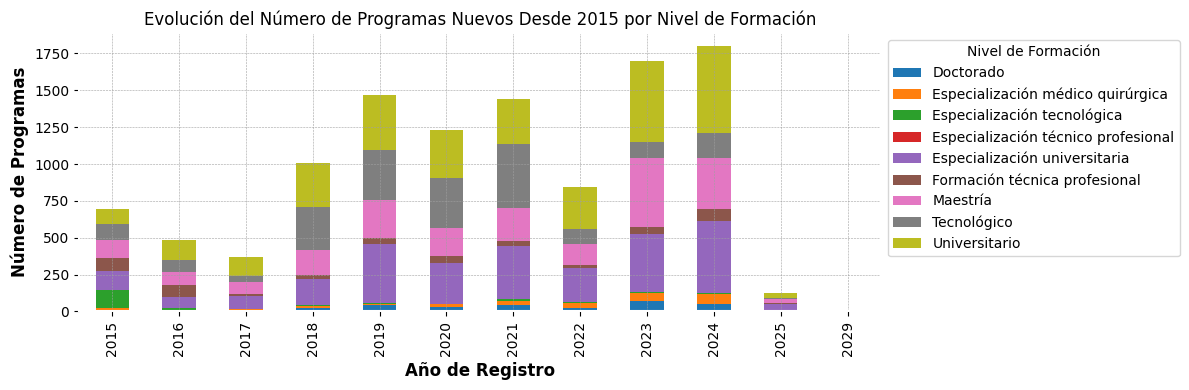

In [233]:
# Agrupar los datos por FECHA_DE_REGISTRO_EN_SNIES y NIVEL_DE_FORMACION
programs_by_level = df_filtered.groupby(
    [df_filtered['FECHA_DE_REGISTRO_EN_SNIES'].dt.year, 'NIVEL_DE_FORMACION']
).size().unstack(fill_value=0)

# Crear la gráfica de columnas apiladas
programs_by_level.plot(kind='bar', stacked=True, figsize=(12, 4))

# Configurar etiquetas y título
plt.title('Evolución del Número de Programas Nuevos Desde 2015 por Nivel de Formación')
plt.xlabel('Año de Registro')
plt.ylabel('Número de Programas')
plt.legend(title='Nivel de Formación', bbox_to_anchor=(1.0, 1), loc='upper left')
plt.tight_layout()

# Mostrar la gráfica
plt.show()

C:\Users\jenni\AppData\Local\Temp\ipykernel_29328\3852086174.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  programs_by_modalidad = df_filtered_from_2015.groupby(


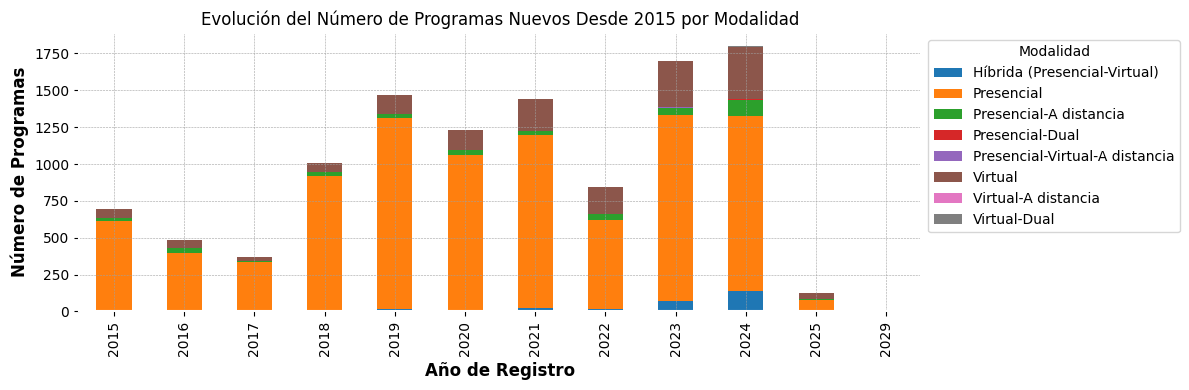

In [234]:
# Agrupar los datos por FECHA_DE_REGISTRO_EN_SNIES y MODALIDAD
programs_by_modalidad = df_filtered_from_2015.groupby(
    [df_filtered_from_2015['FECHA_DE_REGISTRO_EN_SNIES'].dt.year, 'MODALIDAD']
).size().unstack(fill_value=0)

# Crear la gráfica de columnas apiladas
programs_by_modalidad.plot(kind='bar', stacked=True, figsize=(12, 4))

# Configurar etiquetas y título
plt.title('Evolución del Número de Programas Nuevos Desde 2015 por Modalidad')
plt.xlabel('Año de Registro')
plt.ylabel('Número de Programas')
plt.legend(title='Modalidad', bbox_to_anchor=(1.0, 1), loc='upper left')
plt.tight_layout()

# Mostrar la gráfica
plt.show()

C:\Users\jenni\AppData\Local\Temp\ipykernel_29328\2583311997.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary_table = df_filtered_from_2015.groupby(['NIVEL_DE_FORMACION', 'MODALIDAD']).size().reset_index(name='Cantidad_Programas')
C:\Users\jenni\AppData\Local\Temp\ipykernel_29328\2583311997.py:7: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heatmap_data = summary_table.pivot_table(


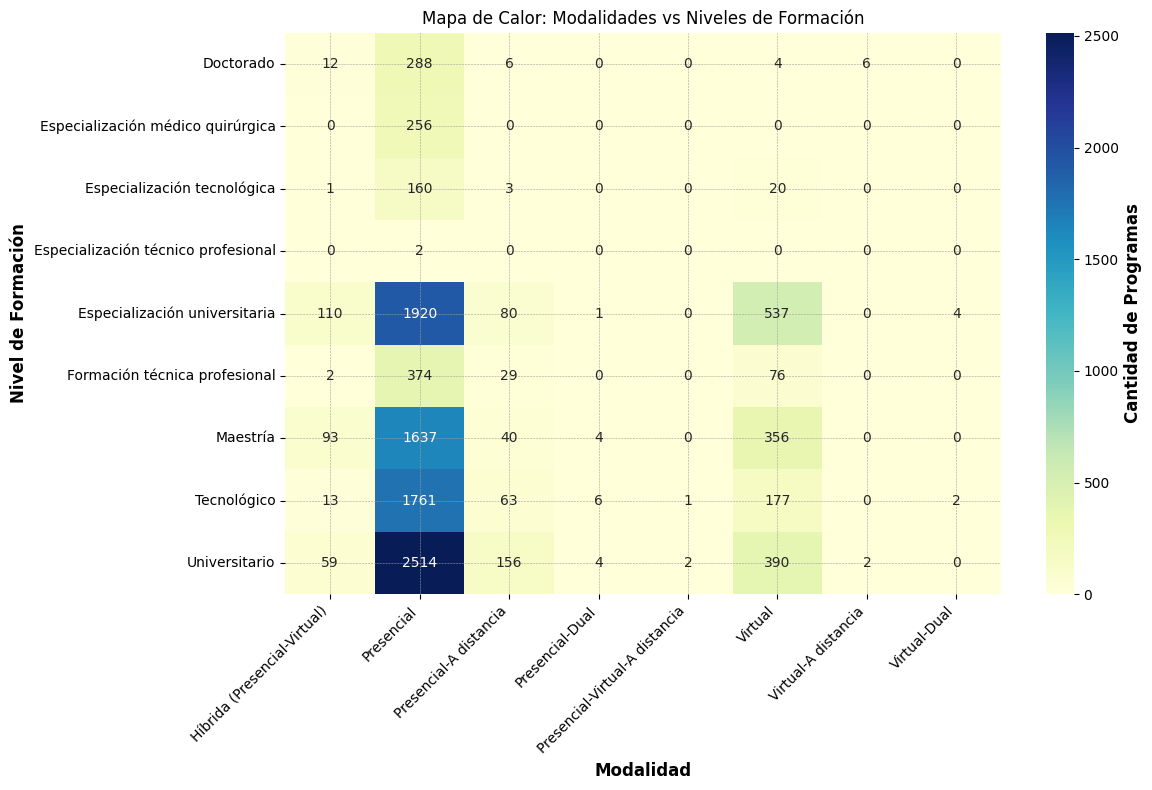

In [235]:
import seaborn as sns

# Crear una tabla resumen para contar la cantidad de programas activos por nivel de formación y modalidad
summary_table = df_filtered_from_2015.groupby(['NIVEL_DE_FORMACION', 'MODALIDAD']).size().reset_index(name='Cantidad_Programas')

# Crear una tabla pivote para sumar la cantidad de programas activos
heatmap_data = summary_table.pivot_table(
    index='NIVEL_DE_FORMACION',
    columns='MODALIDAD',
    values='Cantidad_Programas',
    aggfunc='sum'
)

# Crear el mapa de calor
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, fmt="d", cmap="YlGnBu", cbar_kws={'label': 'Cantidad de Programas'})

# Configurar etiquetas y título
plt.title('Mapa de Calor: Modalidades vs Niveles de Formación')
plt.xlabel('Modalidad')
plt.ylabel('Nivel de Formación')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Mostrar el mapa de calor
plt.show()

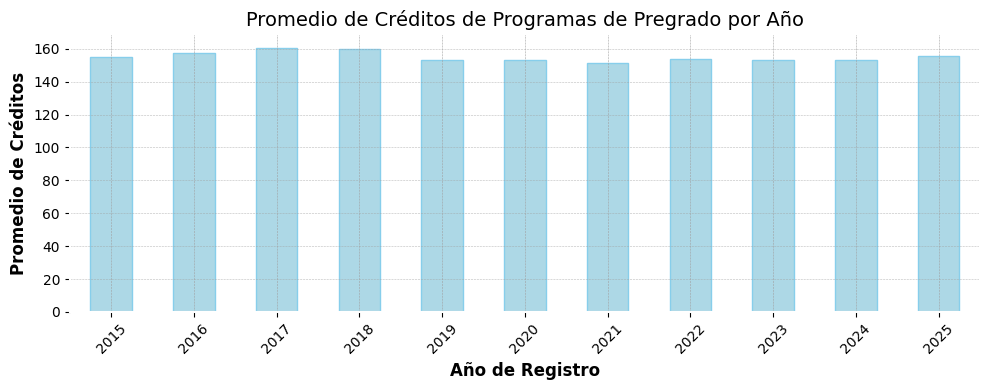

In [242]:
# Filtrar solo los programas de pregrado
pregrado_programs = df_filtered_from_2015[df_filtered_from_2015['NIVEL_DE_FORMACION'] == 'Universitario']

# Agrupar por año y calcular el promedio de créditos
average_credits_by_year = pregrado_programs.groupby(pregrado_programs['FECHA_DE_REGISTRO_EN_SNIES'].dt.year)['NUMERO_CREDITOS'].mean()

# Crear la gráfica
plt.figure(figsize=(10, 4))
average_credits_by_year.plot(kind='bar', color='lightblue', edgecolor='skyblue')

# Configurar etiquetas y título
plt.title('Promedio de Créditos de Programas de Pregrado por Año', fontsize=14)
plt.xlabel('Año de Registro', fontsize=12)
plt.ylabel('Promedio de Créditos', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Mostrar la gráfica
plt.tight_layout()
plt.show()